In [2]:
# Imports
%matplotlib inline
import pandas
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import random
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn import linear_model
import json
import time

#Preview Data
df_orig = pandas.read_csv('/Users/dleung/www/mlcompetition/training.tsv', sep='\t')
df_orig.columns = ['age', 'workclass', 'fnlwgt', 'education', 'educationNum', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'income']
df_orig

,age,workclass,fnlwgt,education,educationNum,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K


In [3]:
# Preprocessing classes
# Split the categories into it's own columns
class OneHotEncoder:       
    def fit(self, data, columns):        
        m, n = np.shape(data)
        dat_matrix = []
        category_map = {}
        idx = 0
        for column in columns:
            distinct_categories = list(set(data[column].values.tolist()))
            
            for category in distinct_categories:
                category_map[column + '_' + category] = idx
                idx += 1
            
            category_map[column + '_unknown'] = idx
            idx += 1
                
        for index, row in data.iterrows():
            row_dict = {}
            for k, v in category_map.items():
                row_dict[k] = 0
            for column in columns:
                value = row[column]

                if row_dict.has_key(column + '_' + value):
                    row_dict[column + '_' + value] = 1
                else:
                    row_dict[column + '_unknown'] = 1

            dat_matrix.append(row_dict)

        column_names = [None] * (1 + max(category_map.values()))
        for k, v in category_map.items():
            column_names[v] = k
        
        self.category_map = category_map

        return pandas.DataFrame(dat_matrix, columns=column_names)
    
    def test(self, data, columns):
        m, n = np.shape(data)
        dat_matrix = []
        
        for index, row in data.iterrows():
            row_dict = {}
            for k, v in self.category_map.items():
                row_dict[k] = 0
            for column in columns:
                value = row[column]

                if row_dict.has_key(column + '_' + value):
                    row_dict[column + '_' + value] = 1
                else:
                    row_dict[column + '_unknown'] = 1

            dat_matrix.append(row_dict)

        column_names = [None] * (1 + max(self.category_map.values()))
        for k, v in self.category_map.items():
            column_names[v] = k

        return pandas.DataFrame(dat_matrix, columns=column_names)
        
    
# Class to scale feature set with zero mean and unit variance
class GaussianScalar:
    def fit(self, data, columns):
        dat_matrix = {}
        column_names = []
        
        self.var = {}
        self.mean = {}
        for column in columns:
            rows = []
            
            col_var = np.std(data[column])
            col_mean = np.mean(data[column])
            
            self.var[column] = col_var
            self.mean[column] = col_mean
            
            for row in data[column]:
                rows.append((row - col_mean) / (col_var))
            
            dat_matrix[column + "_scalar"] = rows
            column_names.append(column + "_scalar")
        
        return pandas.DataFrame(dat_matrix, columns=column_names)
    def test(self, data, columns):
        dat_matrix = {}
        column_names = []
        
        for column in columns:
            rows = []
            
            for row in data[column]:
                rows.append((row - self.mean[column]) / (self.var[column]))
                
            dat_matrix[column + "_scalar"] = rows
            column_names.append(column + "_scalar")
        
        return pandas.DataFrame(dat_matrix, columns=column_names)
    

In [4]:
# Dataset Methods
def loadDataSet(data_columns, rows=None):
    df_orig = pandas.read_csv('/Users/dleung/www/mlcompetition/training.tsv', sep='\t')
    df_orig.columns = data_columns
    if rows != None:
        df_orig = df_orig[0:rows]
        
    df_orig = df_orig.iloc[np.random.permutation(len(df_orig))]
    return df_orig.reset_index(drop=True)

def loadTestSet(data_columns):
    df_test = pandas.read_csv('/Users/dleung/www/mlcompetition/test_final.tsv', sep='\t', header=None)
    df_test.columns = data_columns
    return df_test

def printValidationResults(pred, real):
    df = pandas.DataFrame(np.asarray(pred), columns=['pred'])
    df.insert(1, 'actual', real)

    correct = float(len(df[df.pred == df.actual].index))
    percent_correct = correct / len(df.index)

    print('=========validation results============')
    print('correct: %02f' % correct)
    print('total: %02f' % len(df.index))
    print('%% correct: %05f' % percent_correct)
    

# Load Train, Validation, and Test Sets
data_columns = ['age', 'workclass', 'fnlwgt', 'education', 'educationNum', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'income']
test_data_columns = ['age', 'workclass', 'fnlwgt', 'education', 'educationNum', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'country']

categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'country']
scalar_columns = ['age', 'hours-per-week', 'capital-gain', 'capital-loss']

percent_train = 0.8
rows = None
max_cycles = 2000

df_orig = loadDataSet(data_columns, rows)

categoryEncoder = OneHotEncoder()
scalarEncoder = GaussianScalar()

categorical_df = categoryEncoder.fit(df_orig, categorical_columns)
scalar_df = scalarEncoder.fit(df_orig, scalar_columns)

y_df = pandas.DataFrame(np.where(df_orig.income == "<=50K", 0, 1), columns=['label'])
data_df =  pandas.concat([categorical_df, scalar_df], axis=1)

m, _ = np.shape(data_df)
training_m_rows = int(percent_train * m)

# Generate Training data
train_data_df = data_df[0:training_m_rows]
train_y_df = y_df[0:training_m_rows]

# Generating Validation data
validation_data_df = data_df[training_m_rows:-1].reset_index(drop=True)
validation_y_df = y_df[training_m_rows:-1].reset_index(drop=True)

# Generating TEST data
df_test = loadTestSet(test_data_columns)
test_categorical_df = categoryEncoder.test(df_test, categorical_columns)
test_scalar_df = scalarEncoder.test(df_test, scalar_columns)
test_data_df = pandas.concat([test_categorical_df, test_scalar_df], axis=1)

In [5]:
# Logistic Regression
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

# Batch gradient ascent
def gradAscent(data_orig, y_orig, max_cycles=1000, alpha=0.1, error_delta=0.005):
    data_df = data_orig.copy()
    y_df = y_orig.copy()

    m, n = np.shape(data_df)
    data_df.insert(0, 'zeroth_feature', np.ones((m, 1)))
    n = n + 1
    data = np.mat(data_df)
    y = np.mat(y_df)
    error_sum = float("inf")
    
    weights = np.ones((n, 1))
    errors_x = []
    errors_y = []
    iteration = 0
    while (abs(error_sum) > error_delta) and (iteration < max_cycles):
        if (iteration % 1000 == 0):
            print("Iteration #" + str(iteration))
        # Gradient of sigmoid function
        error = y - sigmoid(data * weights)

        error_sum = np.sum(error)

        errors_x.append(iteration)
        errors_y.append(error_sum)

        weights = weights + alpha * data.transpose() * error
        iteration += 1
    return weights, (errors_x, errors_y)

# Stochastic Gradient Ascent
def stocGradAscent(data_orig, y_orig):
    data_df = data_orig.copy()
    y_df = y_orig.copy()

    m, n = np.shape(data_df)
    data_df.insert(0, 'zeroth_feature', np.ones((m, 1)))
    n = n + 1
    data = np.mat(data_df)
    y = np.mat(y_df)
    
    alpha = 0.01
    
    weights = np.ones((n, 1))
    errors_x = []
    errors_y = []
    
    for i in range(m):
        h = sigmoid(data[i] * weights)
        error = (y[i] - h)[0,0]

        if (i % 1000 == 0):
            print("Iteration Number: " + str(i))
        errors_x.append(i)
        errors_y.append(error)

        weights = weights + alpha * data[i] * error
    return weights, (errors_x, errors_y)

# Minibatch Gradient Ascent
def minibatchstocGradAscent1(data_orig, y_orig, numIter=150, alpha=0.01):
    data_df = data_orig.copy()
    y_df = y_orig.copy()

    m, n = np.shape(data_df)
    data_df.insert(0, 'zeroth_feature', np.ones((m, 1)))
    n = n + 1
    data = np.mat(data_df)
    y = np.mat(y_df)
    
    weights = np.ones((1, n))
    errors_x = []
    errors_y = []
    
    for j in range(numIter):
        data_index = range(m)
        
        if (j % 1000 == 0):
            print("Iteration Number: " + str(j))
        
        for i in range(m):
            alpha = 4 / (1.0 + j + 1) + 0.01
            rand_index = int(random.uniform(0, len(data_index)))
            
            h = sigmoid(data[rand_index] * weights.transpose())
            error = (y[rand_index] - h)[0,0]
            
            weights = weights + alpha * data[rand_index] * error 
            del(data_index[rand_index])
            
        errors_x.append(j)
        errors_y.append(error)
        
    return weights, (errors_x, errors_y)

def classifyVector(test_data_df_orig, weights):
    data_df = test_data_df_orig.copy()
    
    m, n = np.shape(data_df)
    data_df.insert(0, 'zeroth_feature', np.ones((m, 1)))
    
    sig_y = sigmoid(data_df.values * weights)

    sig_y_df = pandas.DataFrame(np.asarray(sig_y.transpose())[0], columns=['y_pred'])
    return pandas.DataFrame(np.where(sig_y_df['y_pred'] >=  0.5, 1, 0), columns=['pred']).values

Iteration #0


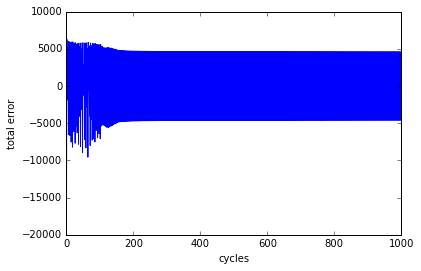

cycles: 1000
final error: -4584.162871
=========validation results============
correct: 5284.000000
total: 6511.000000
% correct: 0.811550


In [7]:
# Perform Logistic Regression
weights, errors = gradAscent(train_data_df, train_y_df, alpha=0.001)

plt.plot(errors[0], errors[1])
plt.ylabel('total error')
plt.xlabel('cycles')
plt.show()

print("cycles: %s" % len(errors[0]))
print("final error: %05f" % errors[1][-1])

# Test on Validation set.  This is pretty accurate to actual test submission
validation_y_pred = classifyVector(validation_data_df, weights)

printValidationResults(validation_y_pred, validation_y_df)

y_test = pandas.DataFrame(np.asarray(classifyVector(test_data_df, weights)), columns=["pred"])

submission_test = pandas.DataFrame(np.where(y_test.pred == 1, ">50K", "<=50K"), columns=['guesses'])
submission = {}
submission['guesses'] = submission_test.guesses.values.tolist()

with open('/Users/dleung/www/mlcompetition/test_final_submission.txt', 'w') as fp:
    json.dump(submission, fp)